## Learning Objectives:
1. [A Step-by-Step Illulstration of Kernelized SVMs](#A-Step-by-Step-Illulstration-of-Kernelized-SVMs)
  - [Step1: Loading a Non-Linearly Separable Dataset](#Step1:-Loading-a-Non-Linearly-Separable-Dataset)
  - [Training Step: Margin Maximization](#Training-Step:-Margin-Maximization)
  - [Training Step: Small and Large Misclassification Penalty $C$ with RBF Kernel Function](#Training-Step:-Small-and-Large-Misclassification-Penalty-$C$-with-RBF-Kernel-Function)
  - [Training Step: Small and Large Kernel Width $\gamma$ with RBF Kernel Function](#Training-Step:-Small-and-Large-Kernel-Width-$\gamma$-with-RBF-Kernel-Function)
  - [Inference Step: Prediction using Support Vectors](#Inference-Step:-Prediction-using-Support-Vectors)
2. [Bias and Variance with SVMs](#Bias-and-Variance-with-SVMs)
  - [Comparison of Varying Kernel Functions](#Comparison-of-Varying-Kernel-Functions)
  - [Comparison of Varying Hyperparameter Combintaion using RBF Kernel](#Comparison-of-Varying-Hyperparameter-Combintaion-using-RBF-Kernel)
3. [Comparison of Classifiers](#Comparison-of-Classifiers)



#### Adapted from the following code repositories:
- Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com)
  - https://github.com/rasbt/python-machine-learning-book-3rd-edition
- Python Data Science Handbook by [Jake VanderPlas](https://www.oreilly.com/library/view/python-data-science/9781491912126/)
  - https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb
- Sklearn
  - https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

# A Step-by-Step Illulstration of Kernelized SVMs

## Step1: Loading a Non-Linearly Separable Dataset

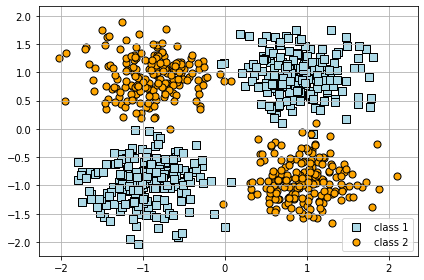

In [6]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('xor.csv')
X = df[['x1', 'x2']].values
y = df['class label'].values


sc = StandardScaler()
sc.fit(X)
X_train_std = sc.transform(X)

plt.scatter(X_train_std[y == 0, 0],
            X_train_std[y == 0, 1],
            s=50, c='lightblue',
            marker='s', edgecolor='black',
            label='class 1')
plt.scatter(X_train_std[y == 1, 0],
            X_train_std[y == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='class 2')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

Using kernel tricks to find separating hyperplanes in higher dimensional space

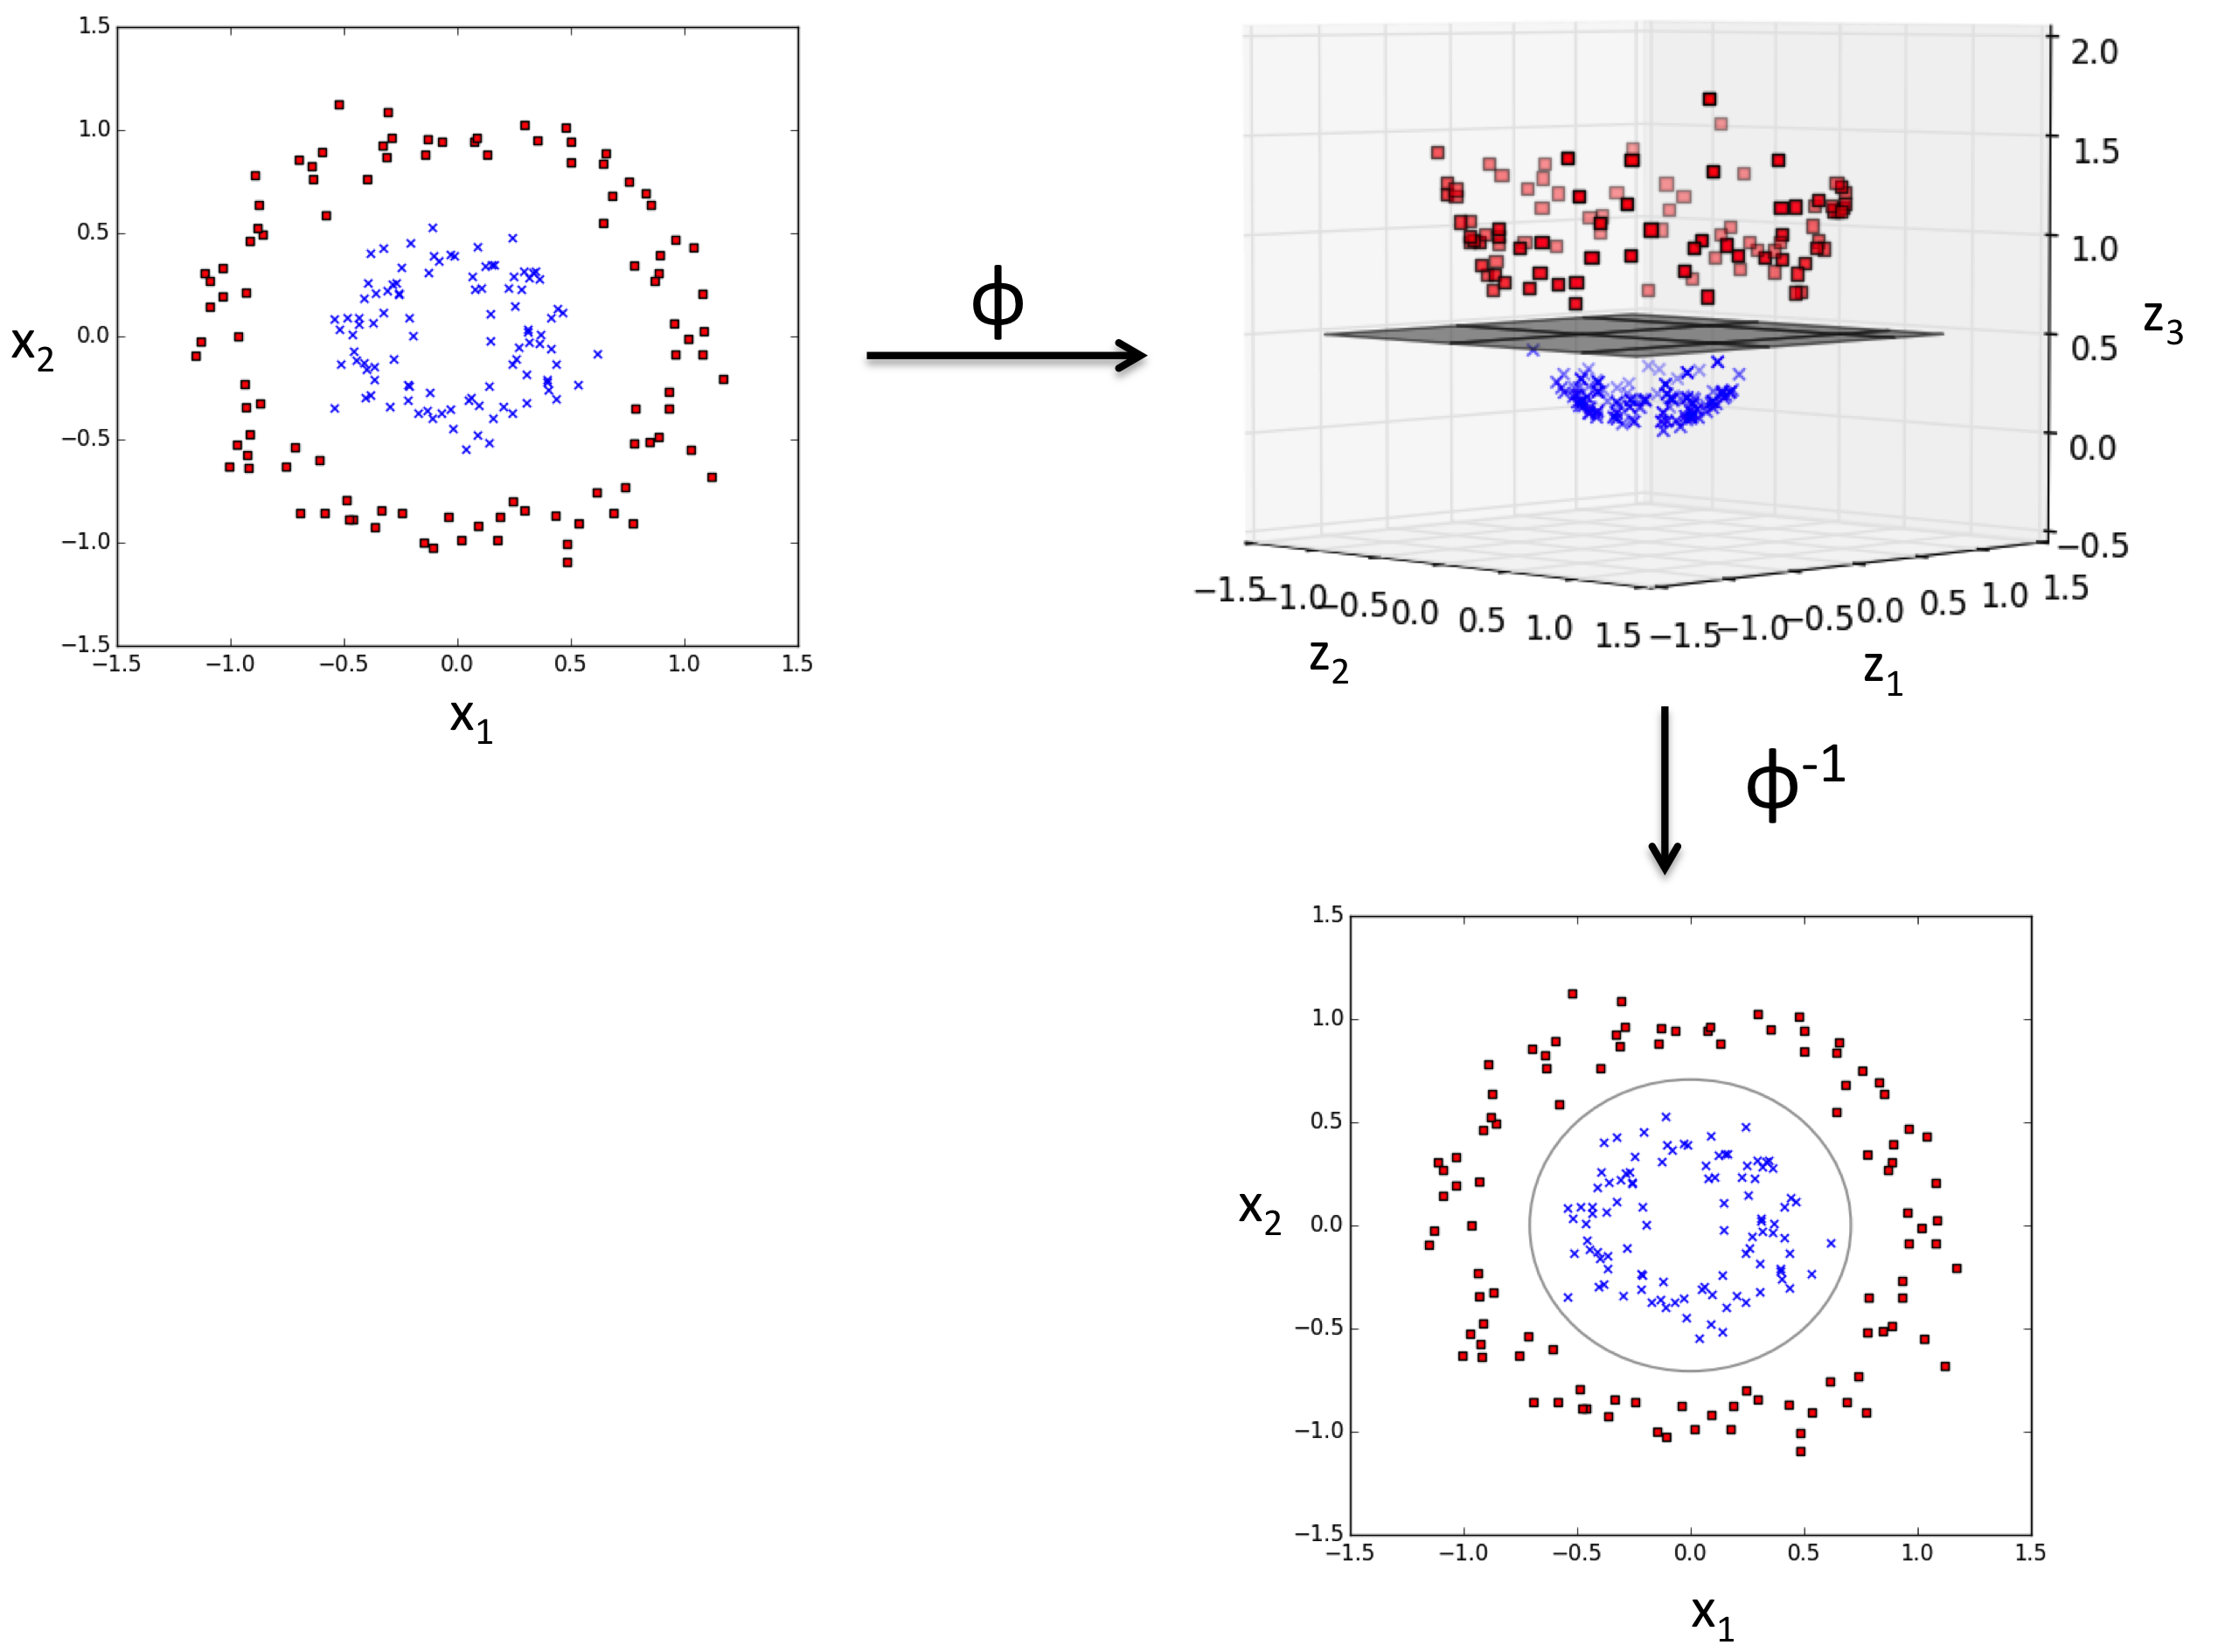

In [8]:
from IPython.display import Image
Image(filename='images/kernelization.png', width=700) 

## Training Step: Margin Maximization

In [37]:
from matplotlib.colors import ListedColormap
from distutils.version import LooseVersion
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, ax, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'o', 'x', '^', 'v')
    colors = ('lightblue', 'orange', 'lightgreen', 'gray', 'cyan')
    background = ('lightcyan', 'cornsilk', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    if ax is None: ax = plt.gca()
    
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label= 'class ' + str(cl+1), 
                    edgecolor='k')
    

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        ax.scatter(X_test[y_test == 0, 0],
                        X_test[y_test == 0, 1],
                        c='blue',
                        edgecolor='blue',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 1)')
        ax.scatter(X_test[y_test == 1, 0],
                        X_test[y_test == 1, 1],
                        c='red',
                        edgecolor='red',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 2)')
        
    ax.set_xlabel('petal length [standardized]', size=16)
    ax.set_ylabel('petal width [standardized]', size=16)
    ax.legend(loc='upper left', fontsize=16)
    

In [8]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolor='black', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

## Training Step: Small and Large Misclassification Penalty $C$ with RBF Kernel Function 

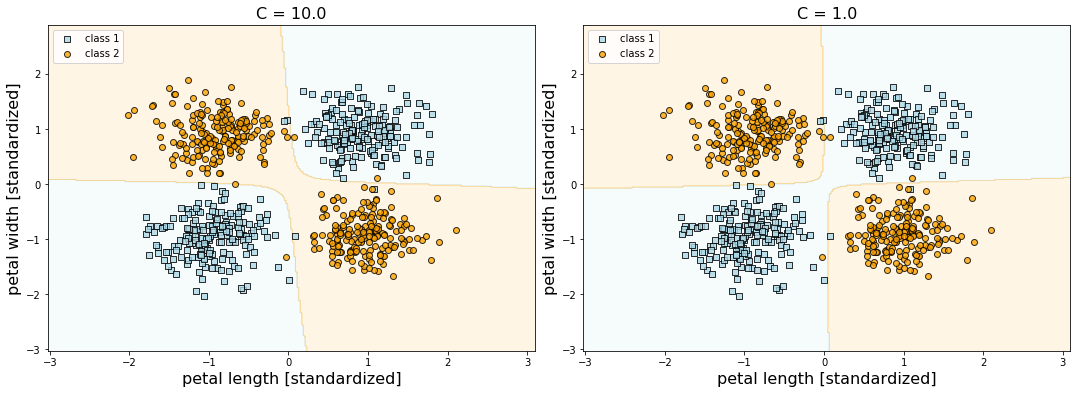

In [11]:
from sklearn.svm import SVC

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 1.0]):
    model = SVC(kernel='rbf', gamma=0.10, C=C).fit(X, y)
    
    plot_decision_regions(X, y, axi, classifier=model)

    axi.set_title('C = {0:.1f}'.format(C), size=16)


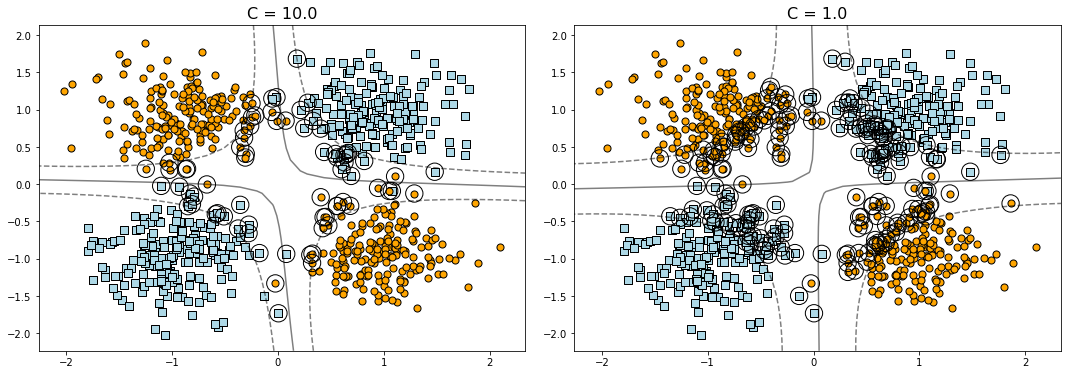

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 1.0]):
    model = SVC(kernel='rbf', gamma=0.10, C=C).fit(X, y)
    
    axi.scatter(X[y == 0, 0],
            X[y == 0, 1],
            s=50, c='lightblue',
            marker='s', edgecolor='black',
            label='class 1')
    axi.scatter(X[y == 1, 0],
                X[y == 1, 1],
                s=50, c='orange',
                marker='o', edgecolor='black',
                label='class 2')
    
    
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=16)

## Training Step: Small and Large Kernel Width $\gamma$ with RBF Kernel Function

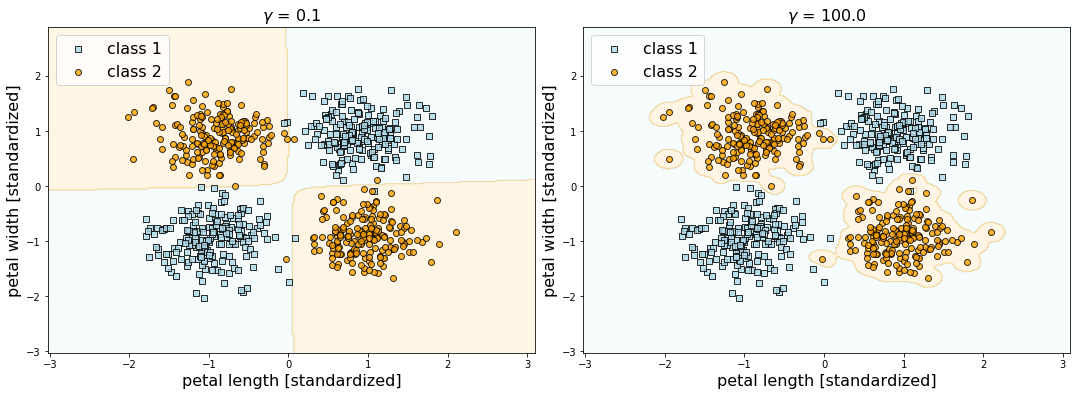

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, gamma in zip(ax, [0.1, 100.0]):
    model = SVC(kernel='rbf', gamma=gamma, C=1.0).fit(X, y)
    
    plot_decision_regions(X, y, axi, classifier=model)#, test_idx=range(105, 150)

    axi.set_title('$\gamma$ = {0:.1f}'.format(gamma), size=16)
plt.savefig('destination_path.pdf', format='pdf')

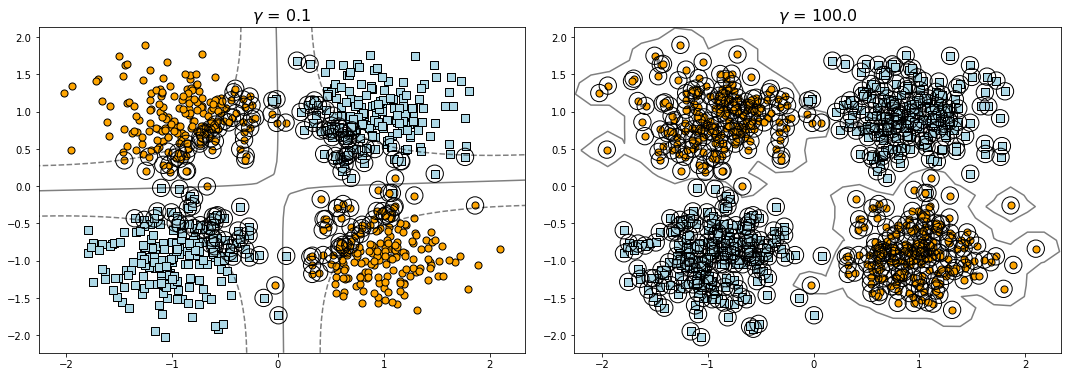

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, gamma in zip(ax, [0.1, 100.0]):
    model = SVC(kernel='rbf', gamma=gamma, C=1.0).fit(X, y)
    
    axi.scatter(X[y == 0, 0],
            X[y == 0, 1],
            s=50, c='lightblue',
            marker='s', edgecolor='black',
            label='class 1')
    axi.scatter(X[y == 1, 0],
                X[y == 1, 1],
                s=50, c='orange',
                marker='o', edgecolor='black',
                label='class 2')
    
    
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('$\gamma$ = {0:.1f}'.format(gamma), size=16)

## Inference Step: Prediction using Support Vectors

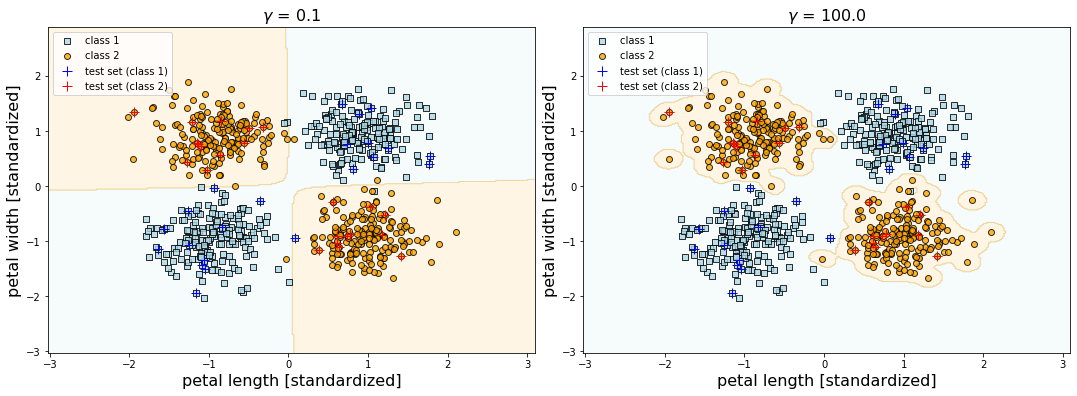

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, gamma in zip(ax, [0.1, 100.0]):
    model = SVC(kernel='rbf', gamma=gamma, C=1.0).fit(X, y)
    
    plot_decision_regions(X, y, axi, classifier=model, test_idx=range(105, 150))

    axi.set_title('$\gamma$ = {0:.1f}'.format(gamma), size=16)
# plt.savefig('softsvm.eps', format='eps')

# Bias and Variance with SVMs
* 10 clasification models of interest 
* 4 commonly seen kernel functions: Linear kernel, RBF kernel, Polynomial kernel, and Sigmoid Kernels
* Regularization parameter $C$ is limit on alphas (for any kernel)
* Gamma $\gamma$ is the kernel bandwidth

A smaller gamma means a wider kernel, which gives a simpler model because the decision boundary will be smoother. Whereas a larger gamma gives a much narrower kernel and thus leads to higher local inference for each data point.
That is, SVM with larger gamma becomes similar to the nearest neighbor algorithm and has higher complexity. Typically, you should tune both gamma and regularization hyperparameters to obtain a good tradeoff between fitting and generalization.

In [106]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [128]:
h = 0.02  # step size in the mesh

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

## Comparison of Varying Kernel Functions

In [116]:
names1 = [
    "Linear SVM",
    "Polynomial SVM",
    "Sigmoid SVM",
    "RBF $\gamma$=0.1, C=1",
    "RBF $\gamma$=1, C=0.1",
]

classifiers1 = [
    SVC(kernel="linear", C=0.025),
    SVC(kernel='poly', random_state=1, gamma=2, C=1),
    SVC(kernel='sigmoid', random_state=1, gamma=2, C=1),
    SVC(kernel='rbf', random_state=1, gamma=0.1, C=1),
    SVC(kernel='rbf', random_state=1, gamma=1, C=0.1),
]

In [144]:
def plot_decision_boundaries(names1, classifiers1):
    figure = plt.figure(figsize=(27, 9))
    i = 1
    # iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42
        )

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        markers = ('s', 'o', '+', '+', 'v')
        colors = ('lightblue', 'orange', 'blue', 'red')
        cmap = ListedColormap(colors[:len(np.unique(y_test))])
        ax = plt.subplot(len(datasets), len(classifiers1) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data", size=20)
        # Plot the training points
        for idx, cl in enumerate(np.unique(y_train)):
            ax.scatter(x=X_train[y_train == cl, 0], 
                            y=X_train[y_train == cl, 1],
                            alpha=1, 
                            s=100, 
                            color=colors[idx],
                            marker=markers[idx], 
                            edgecolor='black')    
        # Plot the testing points
        for idx, cl in enumerate(np.unique(y_test)):
            ax.scatter(x=X_test[y_test == cl, 0], 
                            y=X_test[y_test == cl, 1],
                            alpha=1, 
                            s=100, 
                            color=colors[idx+2],
                            marker='+', 
                            edgecolor=colors[idx+2])

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

        # iterate over classifiers
        for name, clf in zip(names1, classifiers1):
            ax = plt.subplot(len(datasets), len(classifiers1) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)

            # Plot the training points
            for idx, cl in enumerate(np.unique(y_train)):
                ax.scatter(x=X_train[y_train == cl, 0], 
                            y=X_train[y_train == cl, 1],
                            alpha=1, 
                            s=100, 
                            color=colors[idx],
                            marker=markers[idx], 
                            edgecolor='black')

            # Plot the testing points
            for idx, cl in enumerate(np.unique(y_test)):
                ax.scatter(x=X_test[y_test == cl, 0], 
                            y=X_test[y_test == cl, 1],
                            alpha=1, 
                            s=100, 
                            color=colors[idx+2],
                            marker='+', 
                            edgecolor=colors[idx+2])


            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name, size=20)
            ax.text(xx.max() - 0.3,yy.min() + 0.3,("%.2f" % score).lstrip("0"),size=18,horizontalalignment="right",)
            i += 1

    plt.tight_layout()
    plt.show()

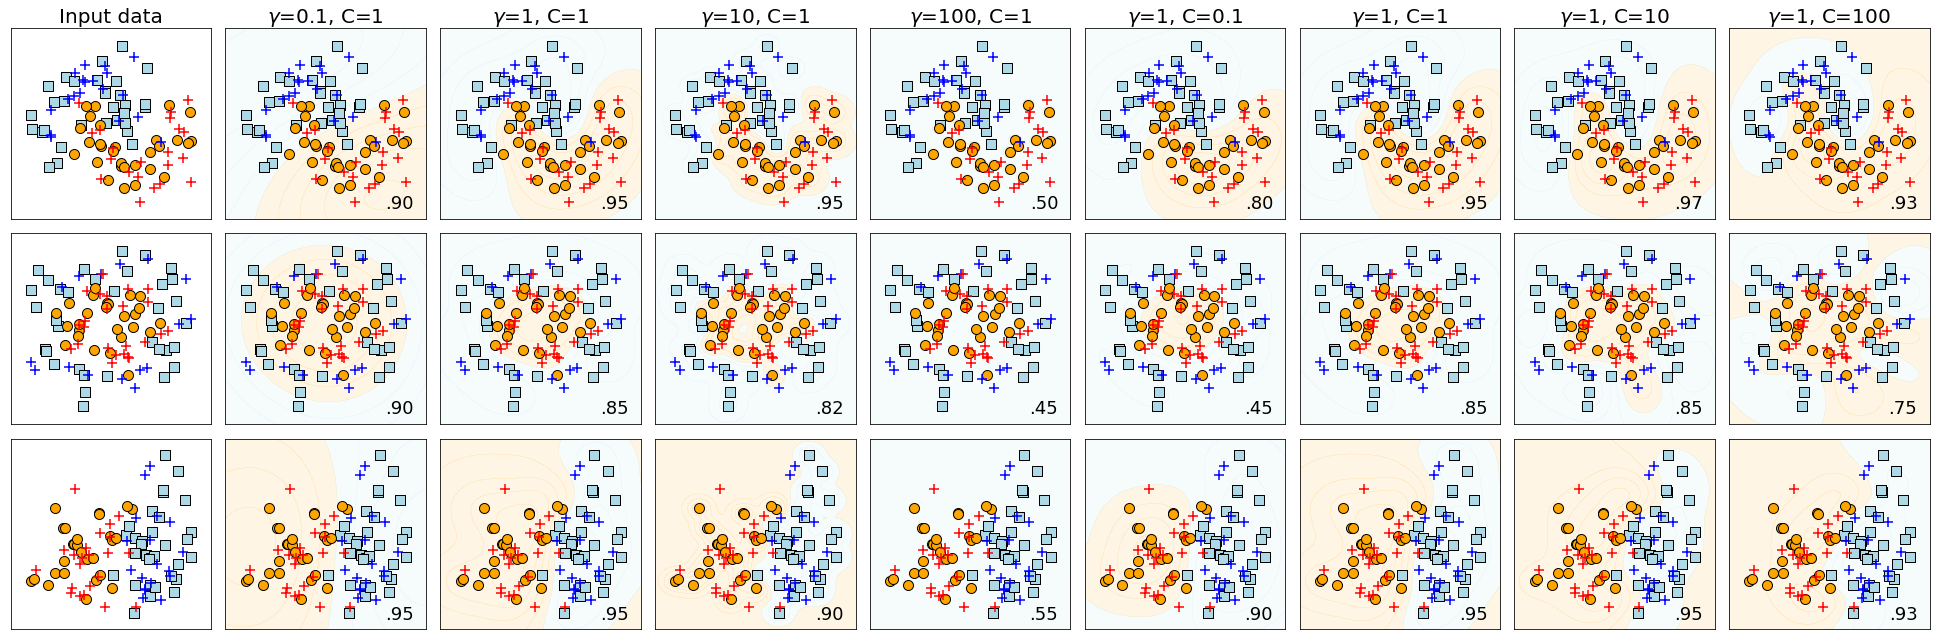

In [145]:
plot_decision_boundaries(names1, classifiers1)

## Comparison of Varying Hyperparameter Combintaion using RBF Kernel

In [146]:
names1 = [
    "$\gamma$=0.1, C=1",
    "$\gamma$=1, C=1",
    "$\gamma$=10, C=1",
    "$\gamma$=100, C=1",
    "$\gamma$=1, C=0.1",
    "$\gamma$=1, C=1",
    "$\gamma$=1, C=10",
    "$\gamma$=1, C=100",
]

classifiers1 = [
    SVC(kernel='rbf', random_state=1, gamma=0.1, C=1),
    SVC(kernel='rbf', random_state=1, gamma=1, C=1),
    SVC(kernel='rbf', random_state=1, gamma=10, C=1),
    SVC(kernel='rbf', random_state=1, gamma=100, C=1),
    SVC(kernel='rbf', random_state=1, gamma=1, C=0.1),
    SVC(kernel='rbf', random_state=1, gamma=1, C=1),
    SVC(kernel='rbf', random_state=1, gamma=1, C=10),
    SVC(kernel='rbf', random_state=1, gamma=1, C=100)
]

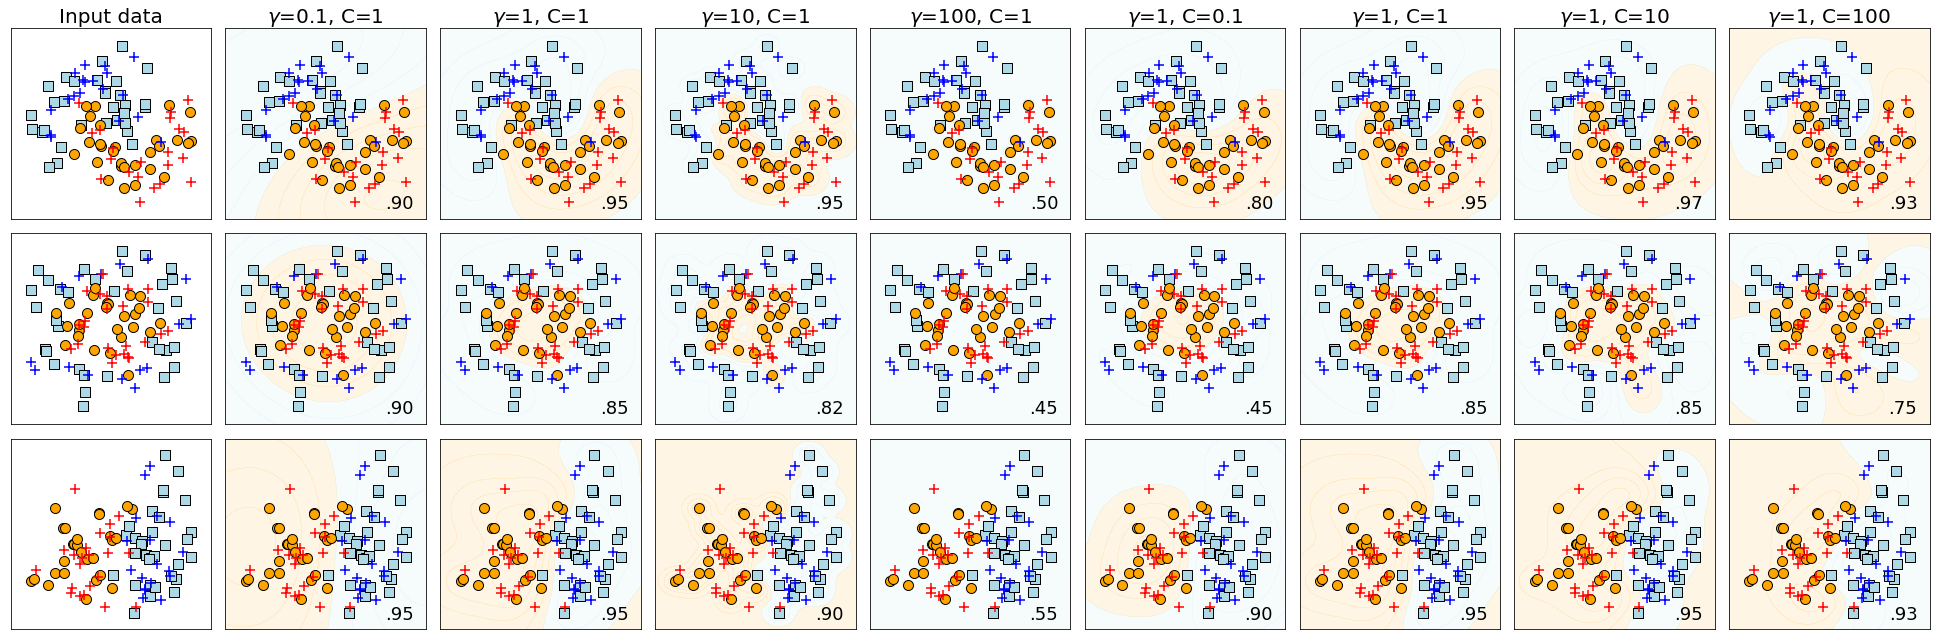

In [147]:
plot_decision_boundaries(names1, classifiers1)

# Comparison of Classifiers
## 7 clasification models

In [148]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB()
]

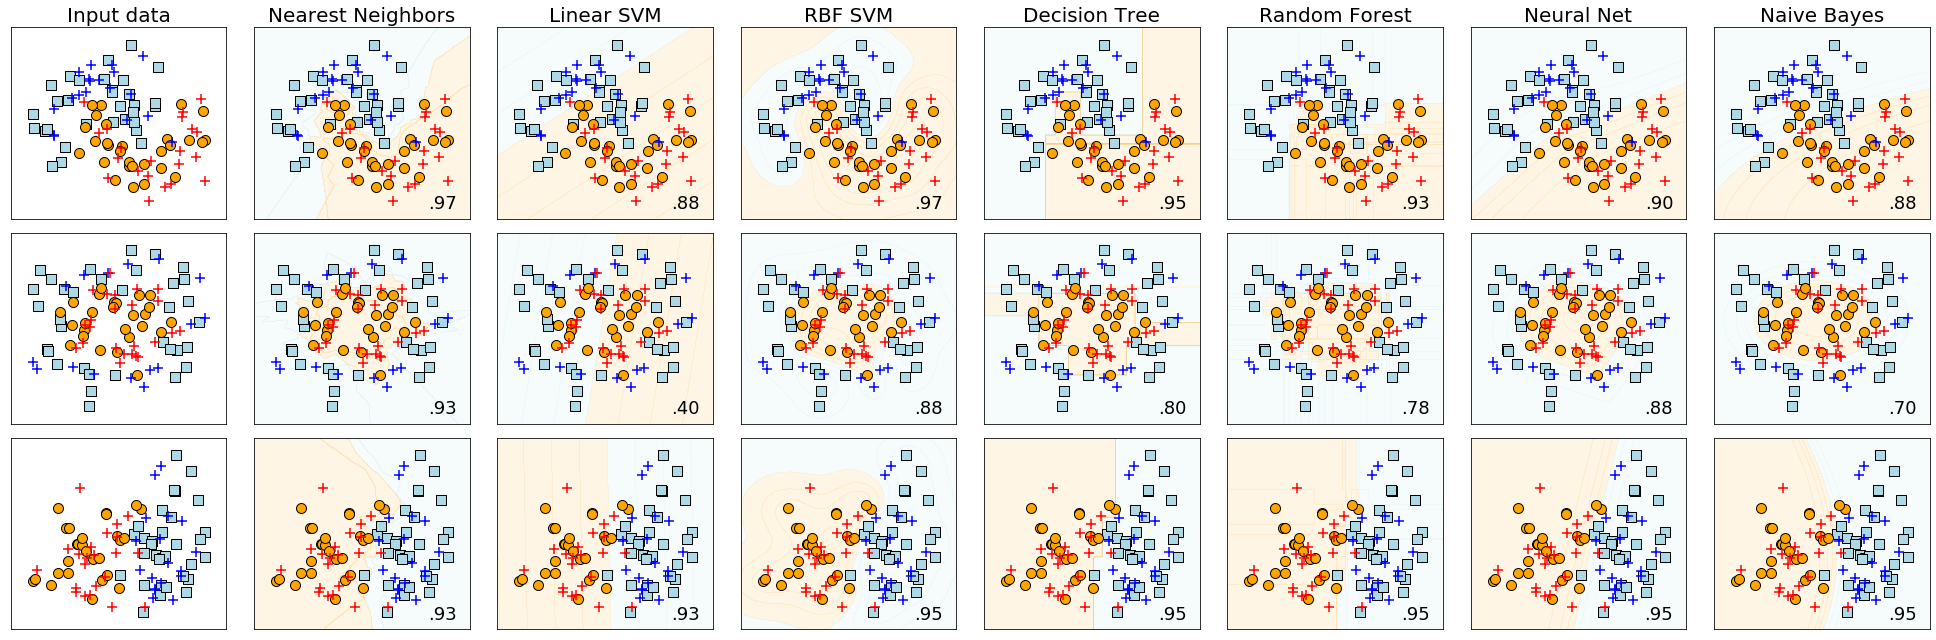

In [149]:
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    markers = ('s', 'o', '+', '+', 'v')
    colors = ('lightblue', 'orange', 'blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y_test))])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data", size=20)
    # Plot the training points
    for idx, cl in enumerate(np.unique(y_train)):
        ax.scatter(x=X_train[y_train == cl, 0], 
                            y=X_train[y_train == cl, 1],
                            alpha=1, 
                            s=100, 
                            color=colors[idx],
                            marker=markers[idx], 
                            edgecolor='black')    
    # Plot the testing points
    for idx, cl in enumerate(np.unique(y_test)):
        ax.scatter(x=X_test[y_test == cl, 0], 
                            y=X_test[y_test == cl, 1],
                            alpha=1, 
                            s=100, 
                            color=colors[idx+2],
                            marker='+', 
                            edgecolor=colors[idx+2])
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
        # Plot the training points
        for idx, cl in enumerate(np.unique(y_train)):
            ax.scatter(x=X_train[y_train == cl, 0], 
                                y=X_train[y_train == cl, 1],
                                alpha=1, 
                                s=100, 
                                color=colors[idx],
                                marker=markers[idx], 
                                edgecolor='black')    
        # Plot the testing points
        for idx, cl in enumerate(np.unique(y_test)):
            ax.scatter(x=X_test[y_test == cl, 0], 
                                y=X_test[y_test == cl, 1],
                                alpha=1, 
                                s=100, 
                                color=colors[idx+2],
                                marker='+', 
                                edgecolor=colors[idx+2])


        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name, size=20)
        ax.text(xx.max() - 0.3, yy.min() + 0.3, ("%.2f" % score).lstrip("0"), size=18, horizontalalignment="right",)
        i += 1

plt.tight_layout()
plt.show()